In [5]:
import numpy as np 
import cv2
import matplotlib.pyplot as plt
import cmath
import time 


In [37]:
class AS_synthesis(object):
    
    def __init__(self,  holo_pixel_size, distance, wavelength, input_matrix_size, error, iter_limit, img_size_for_syn = None):
        
        self.name = 'Angular_spectrum'
        self._chirp_factor = None
        self._inv_chirp_factor = None
        self.holo_pixel_size = holo_pixel_size
        self.distance = distance
        self.wavelength = wavelength
        self.input_matrix_size = input_matrix_size 
        self.error = error
        self.iter_limit = iter_limit 
        self.error_lists = []
        self.scale = self.wavelength * self.distance / (self.input_matrix_size * self.holo_pixel_size**2)       
        
        if img_size_for_syn  is None:
            self.img_size_for_syn = self.input_matrix_size - int(self.input_matrix_size/2)
        elif self.input_matrix_size % self.reshape_img_size != 0:
            print("Некорректный ввод  нового размера изображения, исходный размер  должен делиться на него без остатка")
            exit()
        else: self.img_size_for_syn = img_size_for_syn
                            
    def reshape_img_for_syn(self, input_matrix):
        new_img = np.zeros((self.input_matrix_size, self.input_matrix_size))
        reshape_img = cv2.resize(input_matrix, (self.img_size_for_syn,self.img_size_for_syn))
        index = int((self.input_matrix_size - self.img_size_for_syn) / 2)
        new_img[index:index + self.img_size_for_syn, index:index + self.img_size_for_syn] = reshape_img
        self.reshape_img = reshape_img
        self.new_img = new_img
        return new_img

    def matrix_normalization(self, input_matrix):
        norm_matrix = np.zeros((self.input_matrix_size, self.input_matrix_size)) 
        for i in range (self.input_matrix_size):
            for j in range (self.input_matrix_size):
                element = cmath.phase(input_matrix[i,j])
                if element < 0:
                    element = 2 * np.pi + element
                element = element/(2 * np.pi) * 256
                norm_matrix[i,j] = element
        return norm_matrix.astype('uint8')

    @property
    def chirp_factor(self):
        if self._chirp_factor is None:
            self._chirp_factor = (
                np.exp(
                    np.array([
                        [
                            1j * np.pi * self.scale * ((i- int(self.input_matrix_size / 2))**2 + (j - int(self.input_matrix_size / 2))**2) / self.input_matrix_size
                            for j in range(self.input_matrix_size)
                        ]
                        for i in range(self.input_matrix_size)
                    ])
                )
            ) 
        return self._chirp_factor
     
    @property
    def inv_chirp_factor(self):
        if self._inv_chirp_factor is None:
            self._inv_chirp_factor = np.conj(self.chirp_factor)
        return self._inv_chirp_factor
    
    def angle_spect_transform(self,input_matrix):
        
        transform = np.fft.ifftshift(
            np.fft.fft2(
                np.fft.fftshift(
                    self.chirp_factor * np.fft.ifftshift(
                        np.fft.ifft2(
                            np.fft.ifftshift(
                                input_matrix)
                        )
                    )
                )
            )
        )
        
        return  transform
    
    def inverse_angle_spect_transform(self,input_matrix):
        inv_transform = np.fft.ifftshift(
            np.fft.ifft2(
                np.fft.ifftshift(
                    self.inv_chirp_factor * np.fft.ifftshift(
                        np.fft.fft2(
                            np.fft.fftshift(
                                input_matrix 
                            )
                        )
                    )
                )
            )
        )
        return inv_transform
      
    def initial_approx(self):
        return np.exp(1j * np.random.rand(self.input_matrix_size, self.input_matrix_size))
    
    def prepare_for_angle_spec_transform (self, input_matrix):
        return np.exp(1j * input_matrix * 2 * np.pi / 255)

    def img_recovery(self, holo):
        rec_img = abs(self.angle_spect_transform(self.prepare_for_angle_spec_transform(holo)))
        self.recovery_img  = rec_img 
        index = int((self.input_matrix_size - self.img_size_for_syn) / 2)
        informative_img_zone = rec_img[index:index + self.img_size_for_syn, index:index + self.img_size_for_syn]
        self.informative_img_zone = informative_img_zone
    
    
    def calc_error(self, input_matrix, real_img):
        input_matrix = np.float64(abs(input_matrix))
        real_img = np.float64(abs(real_img))
        a = np.sum(input_matrix**2)
        b = np.sum(real_img**2)
        ab = np.sum(input_matrix*real_img)
        return np.sqrt(1-(ab*ab)/(a*b))

    def __call__(self, input_matrix):
        error_list = []
        start_time = time.time()
        holo = self.initial_approx()
        img = self.reshape_img_for_syn(input_matrix)
        error = float('inf')
        i = 0
        while error > self.error and i < self.iter_limit:
            ref_img = self.angle_spect_transform(holo)
            error = self.calc_error(ref_img, img)
            ref_img = np.sqrt(img) * np.exp(1j*np.angle(ref_img))
            holo = self.inverse_angle_spect_transform(ref_img)
            holo = np.exp(1j*np.angle(holo))
            i += 1 
            error_list.append(error)
            print("Iteration ", i, "error ", error)
            
        self.iteration = i
        self.error_lists.append(error_list)
        holo = self.matrix_normalization(holo)
        self.img_recovery(holo)
        self.holo = holo
        print("--- %s seconds ---" % (time.time() - start_time))
        return holo

In [38]:
transform = AS_synthesis(
    holo_pixel_size = 8e-6,
    distance = 1,
    wavelength = 532e-9,
    input_matrix_size = 1024,
    error = 1e-9,
    iter_limit = 20
)

In [39]:
def save_holo(filename, holo):
    cv2.imwrite(filname,img_2)
    

In [40]:
img_2 = cv2.imread("C:\\Users\\minik\\Desktop\\timur1.jpg", cv2.IMREAD_GRAYSCALE)

Iteration  1 error  0.9218475643660307
Iteration  2 error  0.6514632704668109
Iteration  3 error  0.4838852540307707
Iteration  4 error  0.44579224346318935
Iteration  5 error  0.42802352803711063
Iteration  6 error  0.41715905032931005
Iteration  7 error  0.4095925384968401
Iteration  8 error  0.4039134902827054
Iteration  9 error  0.39943603159058994
Iteration  10 error  0.3957836333047845
Iteration  11 error  0.3927233724112257
Iteration  12 error  0.39011801517165634
Iteration  13 error  0.38786981297912926
Iteration  14 error  0.38590650094603823
Iteration  15 error  0.38416936422796727
Iteration  16 error  0.38261705646675775
Iteration  17 error  0.38121587299794657
Iteration  18 error  0.3799373164722879
Iteration  19 error  0.37876489354829274
Iteration  20 error  0.3776887767769059


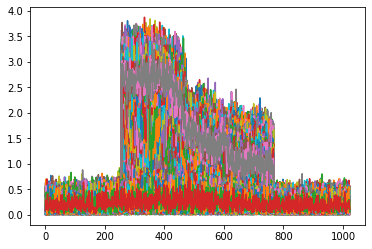

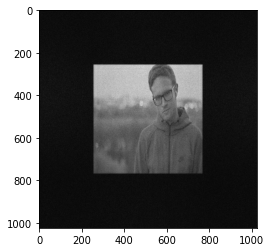

--- 11.614607334136963 seconds ---


In [41]:
holo_2 = transform(img_2)

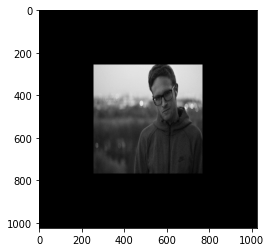

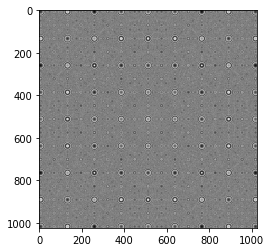

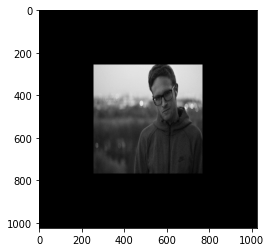

0.0


In [9]:
a  = transform.reshape_img_for_syn(img_2)
plt.imshow(abs(a), cmap='gray')
plt.show() 
c = transform.angle_spect_transform(a)
b= transform.inverse_angle_spect_transform(c)
plt.imshow(abs(b), cmap = 'gray')
plt.show()
print(transform.calc_error(a,b))

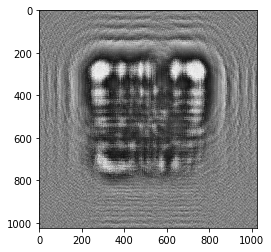

In [16]:
plt.imshow(holo_2, cmap='gray')
plt.show()

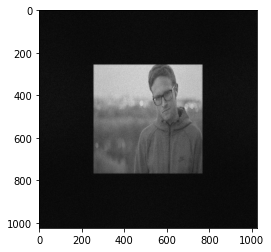

In [19]:
a  = transform.angle_spect_transform(transform.prepare_for_angle_spec_transform(holo_2))
plt.imshow(abs(a), cmap='gray')
plt.show()